# Final Project
## The following describes how do some basis exploratory analysis on taxi data.  The analysis is constrained to the month of January 2017 for the Washington DC area.  The analysis focuses on timeseries analysis and geographic analysis

## Data Source
The data was obtained from opendatadc.gov search for taxi [here] (https://drive.google.com/open?id=0B4JuB6g9n_rmOG9YVk5uWWpZYVU) is the taxi data for Jan, Feb, Mach 2017.


## Library Dependencies
Folium package was used for plotting the MAPS of plot ref: https://python-visualization.github.io/folium/quickstart.html

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np

#plotting libraries
import matplotlib.pyplot as plt 

import folium   #used for plotting maps
import datetime as dt
import random as rnd

## Reading data and removing fields not necesary for the analysis; additionaly outliers are filter out as well

In [2]:
# Reading data file with tzxi data
jan_df = pd.read_csv("/home/stinta/datasets/taxitrip_2017/taxi_201701.txt",sep='|',skipinitialspace=True)

In [3]:
#Exploring fields default types
jan_df.dtypes

OBJECTID                     int64
TRIPTYPE                    object
PROVIDER                    object
METERFARE                  float64
TIP                        float64
SURCHARGE                  float64
EXTRAS                     float64
TOLLS                      float64
TOTALAMOUNT                float64
PAYMENTTYPE                 object
PAYMENTCARDPROVIDER         object
PICKUPCITY                  object
PICKUPSTATE                 object
PICKUPZIP                   object
DROPOFFCITY                 object
DROPOFFSTATE                object
DROPOFFZIP                  object
TRIPMILEAGE                float64
TRIPTIME                   float64
PICKUP_BLOCK_LATITUDE      float64
PICKUP_BLOCK_LONGITUDE     float64
PICKUP_BLOCKNAME            object
DROPOFF_BLOCK_LATITUDE     float64
DROPOFF_BLOCK_LONGITUDE    float64
DROPOFF_BLOCKNAME           object
AIRPORT                     object
PICKUPDATETIME_TR           object
DROPOFFDATETIME_TR          object
dtype: object

In [4]:
# REMOVING selected colums that won't be used for analysis
jan_df.drop(['OBJECTID','TRIPTYPE','PICKUPCITY','PICKUPSTATE','DROPOFFCITY','DROPOFFSTATE','DROPOFFDATETIME_TR','AIRPORT','SURCHARGE','EXTRAS','TOLLS'],axis=1,inplace=True)

In [5]:
# Checking size of dataset
jan_df.shape

(901807, 17)

### Filtering out 'outlier' data

In [6]:
#
jan_df['DROPOFFZIP'] = pd.to_numeric(jan_df['DROPOFFZIP'], errors='coerce',downcast='integer')
jan_df['PICKUPZIP'] = pd.to_numeric(jan_df['PICKUPZIP'], errors='coerce',downcast='integer')

# REMOVING ALL NANa
jan_df.dropna(axis=0, how='any',inplace=True)

#REMOVING NEGATIVE TIP and TOTALAMOUNT
jan_df = jan_df[(jan_df['TIP'] > 0)]
jan_df = jan_df[(jan_df['TOTALAMOUNT'] > 0)]

#REMOVING OUTLIERS for TRIPMILEAGE and TRIPTIME
jan_df = jan_df[(jan_df['TRIPMILEAGE'] < 500)]
jan_df = jan_df[(jan_df['TRIPTIME'] < 480 )]

#RREMOVING ROOW with  Same Pickup and Dropoff Locations (#TODO should be nice to understand the reason)
jan_df = jan_df[~((jan_df['PICKUP_BLOCK_LATITUDE'] == jan_df['DROPOFF_BLOCK_LATITUDE']) & (jan_df['PICKUP_BLOCK_LONGITUDE'] == jan_df['DROPOFF_BLOCK_LONGITUDE']))]


# FORMATING FIELS to use for displaying purposes (setting Location tags smaller for popup on map
jan_df['PICKUP_BLOCKNAME'] = jan_df['PICKUP_BLOCKNAME'].map(lambda x: x.replace('BLOCK OF ','')\
                                                            .replace(' - ','-')\
                                                            .replace('AVENUE','AVE')\
                                                            .replace('STREET','ST')\
                                                           .replace('DRIVE','DR')\
                                                            .replace('PARKWAY','PKWY')\
                                                            .replace('\n','')\
                                                           .replace('ROAD','RD'))

jan_df['DROPOFF_BLOCKNAME'] = jan_df['DROPOFF_BLOCKNAME'].map(lambda x: x.replace('BLOCK OF ','')\
                                                            .replace(' - ','-')\
                                                            .replace('AVENUE','AVE')\
                                                            .replace('STREET','ST')\
                                                           .replace('DRIVE','DR')\
                                                            .replace('PARKWAY','PKWY')\
                                                            .replace('\n','')\
                                                           .replace('ROAD','RD'))



In [7]:
jan_df.shape

(250058, 17)

### setting correct dtypes

In [8]:
jan_df['PICKUPDATETIME_TR'] = pd.to_datetime(jan_df['PICKUPDATETIME_TR'])
jan_df['PICKUPZIP']=jan_df['PICKUPZIP'].astype("int64")
jan_df['DROPOFFZIP']=jan_df['DROPOFFZIP'].astype("int64")

jan_df.dtypes

PROVIDER                           object
METERFARE                         float64
TIP                               float64
TOTALAMOUNT                       float64
PAYMENTTYPE                        object
PAYMENTCARDPROVIDER                object
PICKUPZIP                           int64
DROPOFFZIP                          int64
TRIPMILEAGE                       float64
TRIPTIME                          float64
PICKUP_BLOCK_LATITUDE             float64
PICKUP_BLOCK_LONGITUDE            float64
PICKUP_BLOCKNAME                   object
DROPOFF_BLOCK_LATITUDE            float64
DROPOFF_BLOCK_LONGITUDE           float64
DROPOFF_BLOCKNAME                  object
PICKUPDATETIME_TR          datetime64[ns]
dtype: object

### Sample dataframe contents

In [9]:
jan_df.head()

,PROVIDER,METERFARE,TIP,TOTALAMOUNT,PAYMENTTYPE,PAYMENTCARDPROVIDER,PICKUPZIP,DROPOFFZIP,TRIPMILEAGE,TRIPTIME,PICKUP_BLOCK_LATITUDE,PICKUP_BLOCK_LONGITUDE,PICKUP_BLOCKNAME,DROPOFF_BLOCK_LATITUDE,DROPOFF_BLOCK_LONGITUDE,DROPOFF_BLOCKNAME,PICKUPDATETIME_TR
17,"Transco, Inc.",11.89,2.63,15.77,CreditCard,VisaCredit,20005,20002,1.92,19.0,38.900771,-77.031962,800-899 14TH ST NW,38.896039,-77.007142,40-49 COLUMBUS CIRCLE NE,2017-01-01 16:00:00
18,DCVIP Cab,11.62,3.00,14.87,CreditCard,VisaCredit,20036,20002,2.20,16.0,38.906064,-77.041683,1200-1217 18TH ST NW,38.913714,-77.009049,1724-1799 NORTH CAPITOL ST,2017-01-01 01:00:00
48,United Ventures,4.06,1.00,6.31,CreditCard,MasterCardCredit,20009,20009,0.30,2.0,38.911498,-77.031951,1600-1617 14TH ST NW,38.914093,-77.033900,1416-1499 S ST NW,2017-01-01 22:00:00
81,"Transco, Inc.",6.49,10.00,17.74,CreditCard,VisaCredit,20007,20007,0.80,8.0,38.903007,-77.062763,1000-1025 WISCONSIN AVE NW,38.912214,-77.067896,1645-1679 34TH ST NW,2017-01-01 01:00:00
84,"Transco, Inc.",11.35,2.52,15.12,CreditCard,MasterCardCredit,20001,20002,2.70,14.0,38.916114,-77.021549,631-699 FLORIDA AVE NW,38.914487,-76.981240,2032-2099 WEST VIRGINIA AVE NE,2017-01-01 02:00:00


## Exploring statistics not interesting for analysis but nice to know items

### Which companies provided taxi service in DC for the selected data?

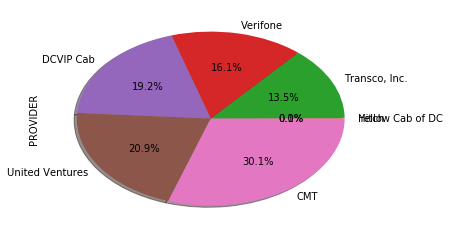

In [10]:
provider_series = jan_df.groupby('PROVIDER').PROVIDER.count()
provider_series.sort_values(inplace=True)
provider_series.plot.pie(autopct='%1.1f%%', shadow=True)

### Which payment type is most popular?

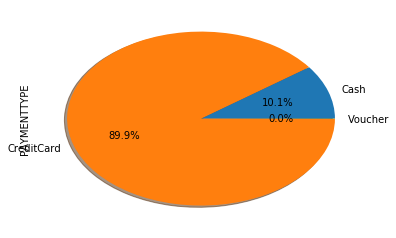

In [11]:
paytype_series = jan_df.groupby('PAYMENTTYPE').PAYMENTTYPE.count()
paytype_series.plot.pie(autopct='%1.1f%%', shadow=True)

### Which zipcode is more popular as a destination zip-code for taxi?

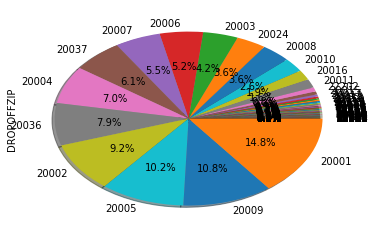

In [12]:
dzip_series = jan_df.groupby('DROPOFFZIP').DROPOFFZIP.count()
dzip_series.sort_values(inplace=True)

dzip_series.plot.pie(autopct='%1.1f%%', shadow=True)

### Which zipcode is more popular as a originating zip-code for taxi?

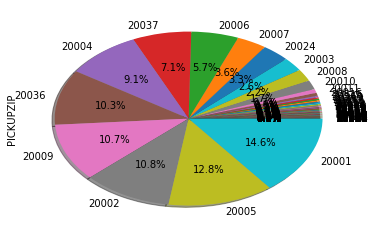

In [13]:
pzip_series = jan_df.groupby('PICKUPZIP').PICKUPZIP.count()
pzip_series.sort_values(inplace=True)

pzip_series.plot.pie(autopct='%1.1f%%', shadow=True)

### What was the range of fares for data presented?
It seems that most people pay up to $35 for most  rides

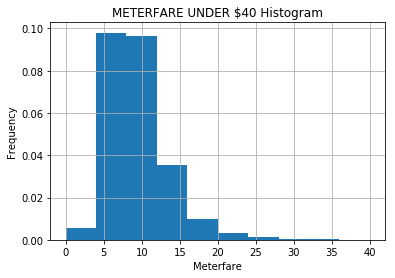

In [14]:
plt.title("METERFARE UNDER $40 Histogram")
plt.xlabel("Meterfare")
plt.ylabel("Frequency")
jan_df.METERFARE[jan_df.METERFARE <40].hist(normed=1)

### How generous people are at tipping?

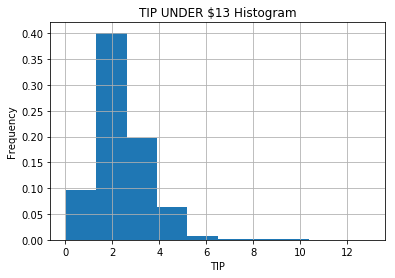

In [15]:
plt.title("TIP UNDER $13 Histogram")
plt.xlabel("TIP")
plt.ylabel("Frequency")
jan_df.TIP[jan_df.TIP <13].hist(normed=1)

### Exploring correlation between trip-mileage and trip-time
From the scatter plot generated, it can be noted that data shows a bimodal behavior.  However trips that record more than 50 miles in less than 25 minutes are definately outlier

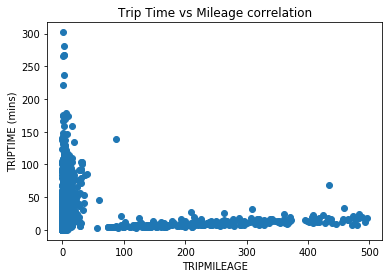

In [16]:
plt.title("Trip Time vs Mileage correlation")
plt.xlabel('TRIPMILEAGE')
plt.ylabel('TRIPTIME (mins)')
plt.scatter(jan_df['TRIPMILEAGE'],jan_df['TRIPTIME'])

### Removing identified outliers from time/mileage correlation plot

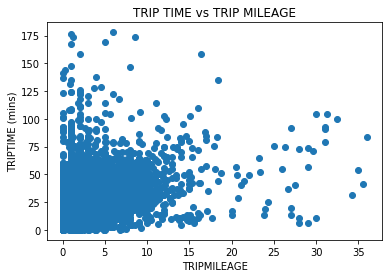

In [17]:
jan_df_largetime = jan_df[(jan_df['TRIPMILEAGE']<40) & (jan_df['TRIPTIME']< 200)]
plt.title("TRIP TIME vs TRIP MILEAGE")
plt.xlabel('TRIPMILEAGE')
plt.ylabel("TRIPTIME (mins)")
plt.scatter(jan_df_largetime['TRIPMILEAGE'],jan_df_largetime['TRIPTIME'])

### From the plot below, it is interested to see that shorter trips can take such a range of time.  Of course that undestanding the context of the DC traffic; the times are valid ranges of data

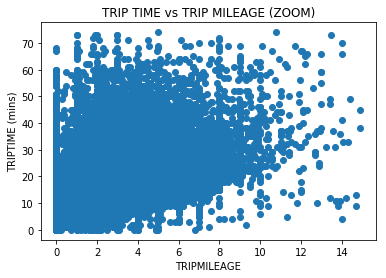

In [18]:
jan_df_largetime = jan_df[(jan_df['TRIPMILEAGE']<15) & (jan_df['TRIPTIME']< 75)]
plt.title("TRIP TIME vs TRIP MILEAGE (ZOOM)")
plt.xlabel('TRIPMILEAGE')
plt.ylabel("TRIPTIME (mins)")
plt.scatter(jan_df_largetime['TRIPMILEAGE'],jan_df_largetime['TRIPTIME'])

## INTIAL ATTEMPT TO PLOT Time Series Data For analysis
The plots have a lot of data being displayed and it doesn't help on the analys; an attempt to break down the data and aggregate based on the mean.  However, periodicity of the data is clear

(array([ 736330.,  736337.,  736344.,  736351.,  736358.]),
 <a list of 5 Text xticklabel objects>)

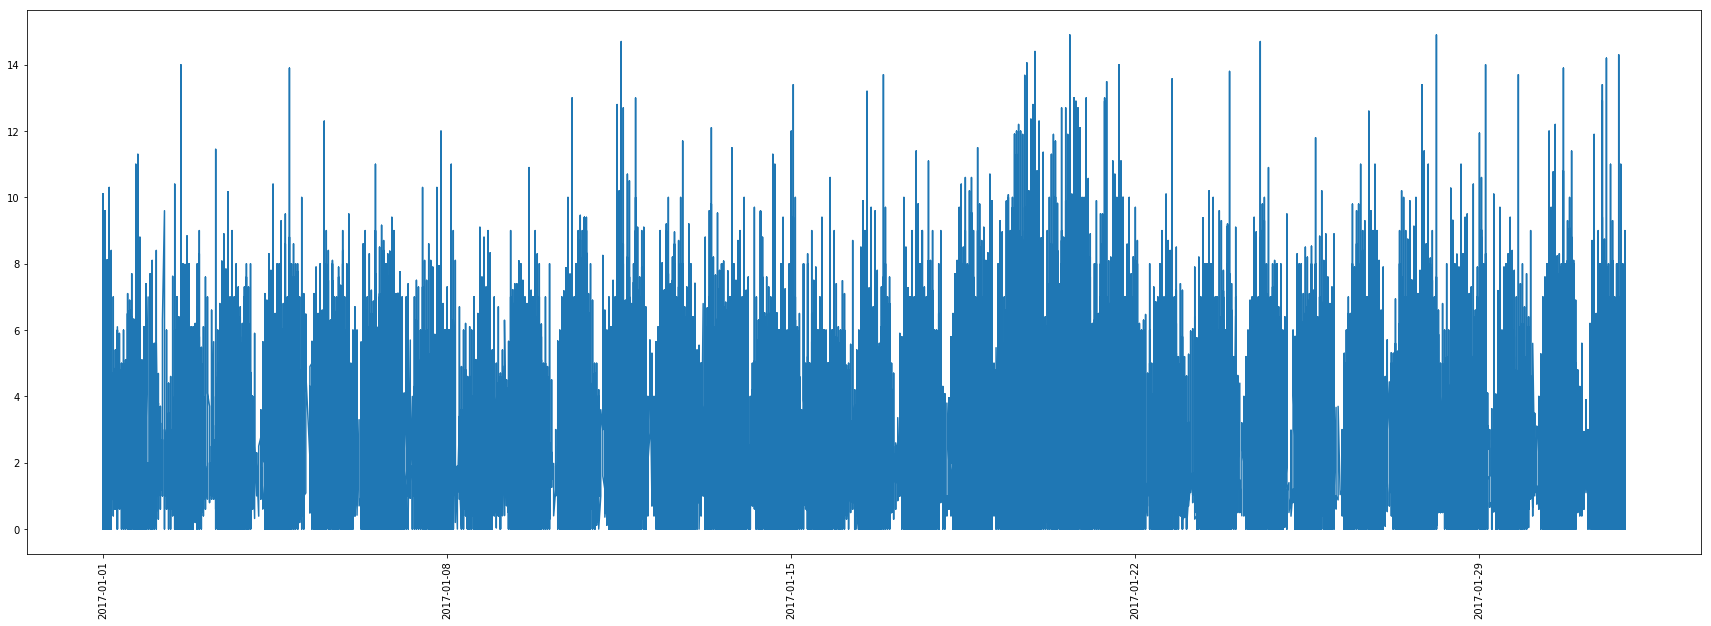

In [19]:
jan_timeseries = jan_df_largetime.sort_values(by='PICKUPDATETIME_TR')
plt.figure(figsize=(30,10))
plt.plot(jan_timeseries['PICKUPDATETIME_TR'],jan_timeseries['TRIPMILEAGE'])
plt.xticks(rotation='vertical')

(array([ 736330.,  736337.,  736344.,  736351.,  736358.]),
 <a list of 5 Text xticklabel objects>)

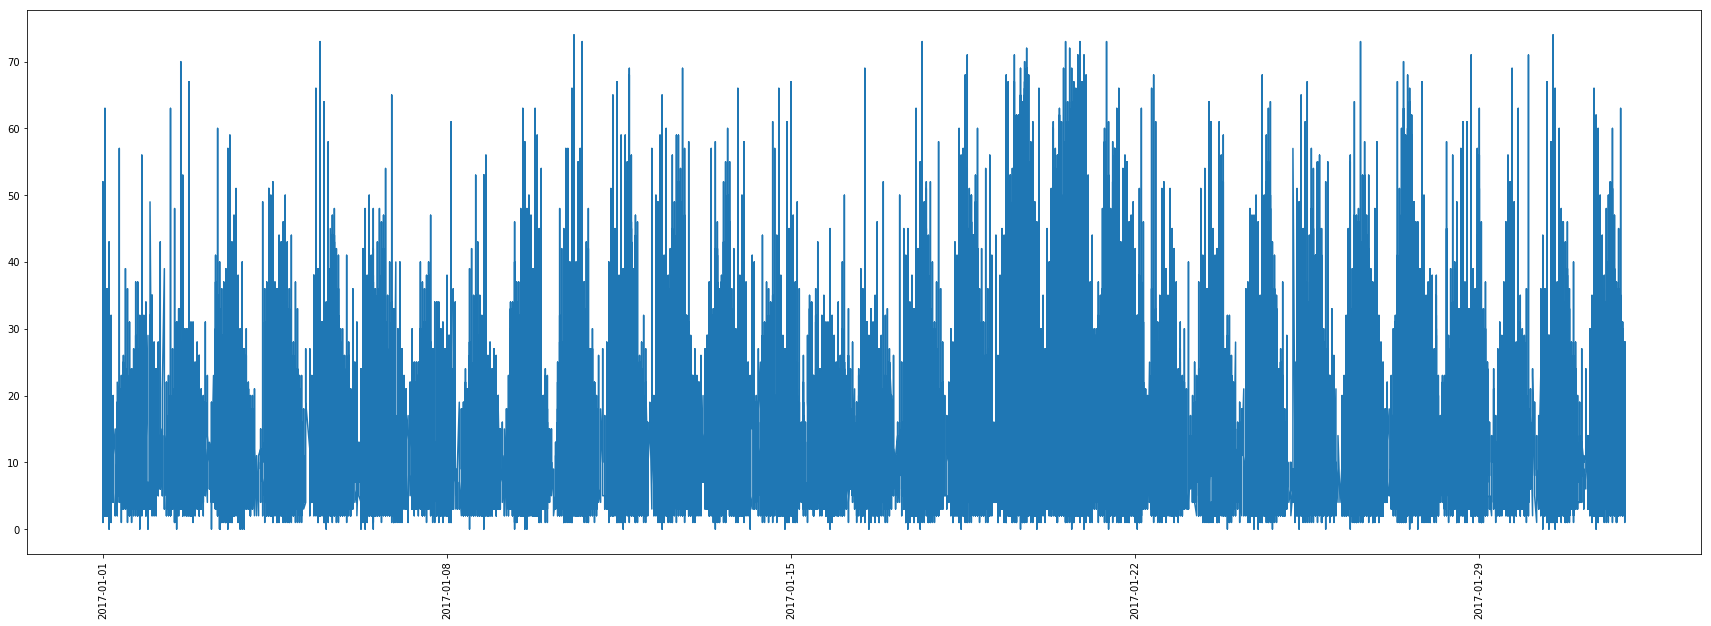

In [20]:
jan_timeseries = jan_df_largetime.sort_values(by='PICKUPDATETIME_TR')
plt.figure(figsize=(30,10))
plt.plot(jan_timeseries['PICKUPDATETIME_TR'],jan_timeseries['TRIPTIME'])
plt.xticks(rotation='vertical')

### Plotting Time and Mileage to observe average daily/hourly trends

One of the things that can be noted is that trips in the afternoon (specially between 3pm and 7pm) trips regardless of the milleage take longer time

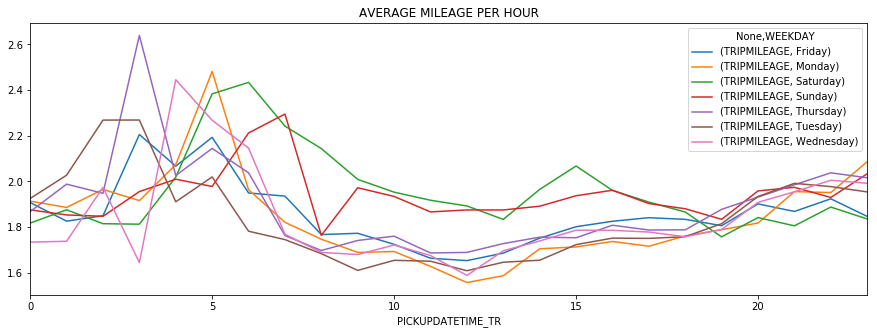

In [21]:
jan_timeseries = jan_df_largetime.sort_values(by='PICKUPDATETIME_TR')
jan_timeseries = jan_timeseries[['TRIPMILEAGE','PICKUPDATETIME_TR']]
jan_timeseries['WEEKDAY'] = jan_timeseries['PICKUPDATETIME_TR'].dt.weekday_name
mileage_data=jan_timeseries.groupby([jan_timeseries['PICKUPDATETIME_TR'].dt.hour, 'WEEKDAY']).mean().unstack()

#plt.figure(5,20)
mileage_data.plot(figsize=(15,5),title="AVERAGE MILEAGE PER HOUR")

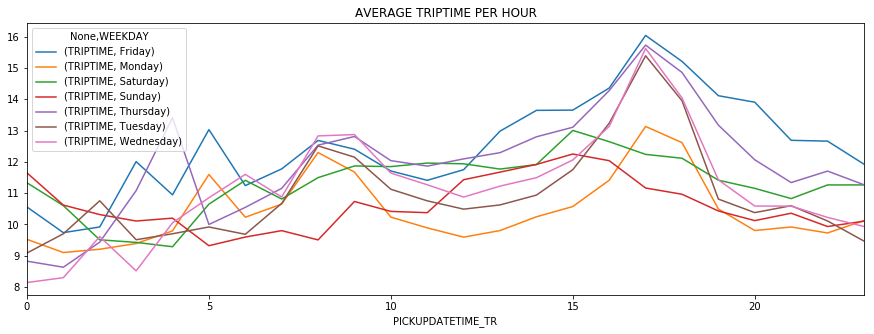

In [22]:
jan_timeseries = jan_df_largetime.sort_values(by='PICKUPDATETIME_TR')
jan_timeseries = jan_timeseries[['TRIPTIME','PICKUPDATETIME_TR']]
jan_timeseries['WEEKDAY'] = jan_timeseries['PICKUPDATETIME_TR'].dt.weekday_name
time_data = jan_timeseries.groupby([jan_timeseries['PICKUPDATETIME_TR'].dt.hour, 'WEEKDAY']).mean().unstack()
time_data.plot(figsize=(15,5),title="AVERAGE TRIPTIME PER HOUR")

# Preparing to do Geographic Analysis

### Helper function to return relevant coordinates to plot

In [23]:
## HELPER FUNCITON TO RETURN RELEVANT COORDINATES TO PLOT AND A HISTOGRAM TO DECIDE IF
# THRESHOLF USED IS RELEVANT
def get_pre_process_locs_toplot(month_df,criteria_list,thresh,count_tag):
    all_coords_df = month_df[criteria_list]
    
    grp_coords = all_coords_df.groupby(criteria_list)

    grp_coords = grp_coords.aggregate(len)
    uniq_coords = grp_coords.reset_index().rename(columns={0: count_tag})
    uniq_coords = uniq_coords[uniq_coords[count_tag] > thresh]
   # hist_plot = uniq_coords[count_tag].hist()
    uniq_coords_lst = uniq_coords.values.tolist()
    #return uniq_coords_lst,hist_plot
    return uniq_coords_lst

## Helper function that returns the plot of the map; this helper is setting labels, tag colors, popup clickable info; as well ass setting the radios of the CircleMarker to represent the count density of pick-up and drop-off locaitons

In [24]:
## HELPER FUNCTION THAT RETURNS THE PLOT OF THE MAP
## THIS HELPER IS SETTING LABELS and TAG COLORS and POPUP (INFO)
def get_map_to_plot(map_type_tag,coords_to_plot):
    #DC CENTER Coordinates
    DC_COORD = [38.895458, -77.016278]

    # Build map 
    map_dc = folium.Map(location=DC_COORD, zoom_start=11.5, 
    tiles='OpenStreetMap', width=640, height=480)
    

    mcolor = '#0080bb'

    
    if map_type_tag == 'DROPOFF':
        mcolor = '#70a050'
        
    if map_type_tag == 'PICKUP_DROPOFF_COUNT':
        #['PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE','PICKUP_BLOCKNAME','DROPOFF_BLOCK_LATITUDE','DROPOFF_BLOCK_LONGITUDE','DROPOFF_BLOCKNAME']
        # Plot coordinates using comprehension list
        [folium.CircleMarker(coords_to_plot[i][3:5],
                         radius = coords_to_plot[i][6]//10,
                         color = '#70a050',
                         fill_color = '#70a050',
                         popup =folium.Popup(coords_to_plot[i][5]+" ("+"PICKUP"+"s:"+str(coords_to_plot[i][6])+")" ,parse_html = True))
                 .add_to(map_dc) 
        for i in range(len(coords_to_plot))]
        
        [folium.CircleMarker(coords_to_plot[i][0:2],
                         radius = coords_to_plot[i][6]//10,
                         color = mcolor,
                         fill_color = mcolor,
                         popup =folium.Popup(coords_to_plot[i][2]+" ("+"DROPOFF"+"s:"+str(coords_to_plot[i][6])+")" ,parse_html = True))
                 .add_to(map_dc) 
        for i in range(len(coords_to_plot))]
      
    else:
    
        # Plot coordinates using comprehension list
        [folium.CircleMarker(coords_to_plot[i][0:2],
                         radius = coords_to_plot[i][3]//500,
                         color = mcolor,
                         fill_color =mcolor,
                         popup =folium.Popup(coords_to_plot[i][2]+" ("+map_type_tag+"s:"+str(coords_to_plot[i][3])+")" ,parse_html = True))
                 .add_to(map_dc) 
        for i in range(len(coords_to_plot))]
    
    return map_dc


## Finding out what is the most popular pick-up locations (with counts); click on marker for quantities

### the function returns the coordinates with counts to pass to the geo plotting function; using a theshold to select most popular ones

In [25]:
criteria_list = ['PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE','PICKUP_BLOCKNAME']
uniq_pickup_coords_lst = get_pre_process_locs_toplot(jan_df,criteria_list,300,'PICKUP_COUNT')


In [26]:
# NUMBER OF LOCATIONS RETURNED (with at least 300 instances)
len(uniq_pickup_coords_lst)

223

In [27]:
t0 = dt.datetime.now()
pickup_map_dc = get_map_to_plot('PICKUP',uniq_pickup_coords_lst)

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

Total time: 4 seconds


### POPULAR PICKUP LOCATIONS

In [28]:
pickup_map_dc

## Finding out what is the most popular drop-off locations (with counts); click on marker for quantities


In [29]:
criteria_list = ['DROPOFF_BLOCK_LATITUDE','DROPOFF_BLOCK_LONGITUDE','DROPOFF_BLOCKNAME']
uniq_dropoff_coords_lst = get_pre_process_locs_toplot(jan_df,criteria_list,300,'DROPOFF_COUNT')

In [30]:
len(uniq_dropoff_coords_lst)

175

In [31]:
t0 = dt.datetime.now()
dropoff_map_dc = get_map_to_plot('DROPOFF',uniq_dropoff_coords_lst)

t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

Total time: 3 seconds


### POPULAR DROP OFF LOCATIONS (click for counts)

In [32]:
dropoff_map_dc

## Finding out what is the MOST popular pick-up and  drop-off pair locations (with counts); click on marker for quantities

In [33]:
criteria_list = ['PICKUP_BLOCK_LATITUDE','PICKUP_BLOCK_LONGITUDE','PICKUP_BLOCKNAME','DROPOFF_BLOCK_LATITUDE','DROPOFF_BLOCK_LONGITUDE','DROPOFF_BLOCKNAME']
uniq_pickupdropoff_coords_lst = get_pre_process_locs_toplot(jan_df,criteria_list,100,'PICKUP_DROPOFF_COUNT')

In [34]:

len(uniq_pickupdropoff_coords_lst)

2

In [35]:
t0 = dt.datetime.now()
pickdrop_dc = get_map_to_plot('PICKUP_DROPOFF_COUNT',uniq_pickupdropoff_coords_lst)
t1 = dt.datetime.now()
print('Total time: %i seconds' % (t1 - t0).seconds)

Total time: 0 seconds


### POPULAR DROP OFF LOCATIONS (click for counts)
### In this case (Based on our theshhold) we were able to determine that the most popular taxi trip for the month of January 2017 in Washington DC was:
- ROUND TRIP: between UNION STATION and most likely the HOTEL MARRIOT (900-999 MASSACHUSETTS AVE NW)

In [36]:
pickdrop_dc